In [1]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [19]:
# Размер входного изображения сети
img_size = (224, 224)

#### Функции загрузки данных

In [4]:
# Загружаем входное изображение и предобрабатываем
def load_image(path, target_size=img_size):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return preprocess_input(img)  # Use ResNet50's preprocess_input

# Функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        np.random.shuffle(files)
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            x = np.array([load_image(file) for file in batch_files])
            y = np.array([1.0 if 'dog' in os.path.basename(file) else 0. for file in batch_files])
            yield (x, y)

# Функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            img = load_image(path)
            yield np.array([img])

In [5]:
train_files = glob('dogs-vs-cats/train/*.jpg')
test_files = glob('dogs-vs-cats/test/*.jpg')

In [6]:
labels = [os.path.split(path)[-1].split('.')[0] for path in train_files]

#### Визуализируем примеры для обучения

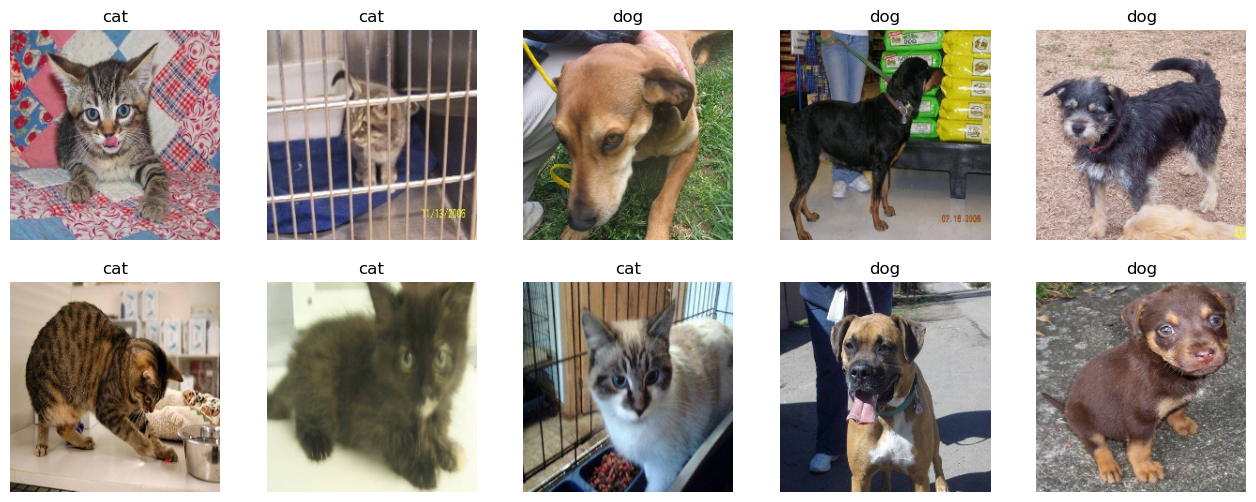

In [7]:
rnd_idx = np.random.choice(len(train_files), size=10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i, ax in enumerate(axes.ravel()):
    img = cv2.imread(train_files[rnd_idx[i]])
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.set_title(labels[rnd_idx[i]])
    ax.imshow(img)
    ax.axis('off')
plt.show()

#### Загружаем предобученную модель

In [8]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(img_size[0], img_size[1], 3))

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

In [11]:
model = Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

#### Компилируем модель и запускаем обучение

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
val_samples = 16  # Число изображений в валидационной выборке
np.random.shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

model.fit(train_data,
          steps_per_epoch=len(train_files) // 32,
          validation_data=validation_data,
          epochs=50,
          callbacks=[checkpoint, early_stopping])

Epoch 1/50
781/781 [==============================] - 77s 91ms/step - loss: 0.0783 - accuracy: 0.9771 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 2/50
781/781 [==============================] - 70s 89ms/step - loss: 0.0399 - accuracy: 0.9868 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/50
781/781 [==============================] - 70s 89ms/step - loss: 0.0300 - accuracy: 0.9892 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/50
781/781 [==============================] - 73s 93ms/step - loss: 0.0302 - accuracy: 0.9906 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/50
781/781 [==============================] - 72s 92ms/step - loss: 0.0281 - accuracy: 0.9901 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/50
781/781 [==============================] - 72s 93ms/step - loss: 0.0223 - accuracy: 0.9920 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/50
781/781 [==============================] - 71s 92ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.0017 - val_accuracy:

In [21]:
model.save('cats-dogs-ResNet50.hdf5')

#### Предсказания на проверочной выборке

In [16]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 173s 14ms/step


#### Готовим файл к отправке

In [18]:
import re

with open('submit_.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))